In [1]:
from pathlib import Path
from IPython.display import HTML, display
import os
import base64
import shutil

Tests in archive: 75 (451 questions)
Tests left: 84


Q,question.png,answer.png
Q1,,
Q2,,
Q3,,
Q4,,
Q5,,
Q6,,

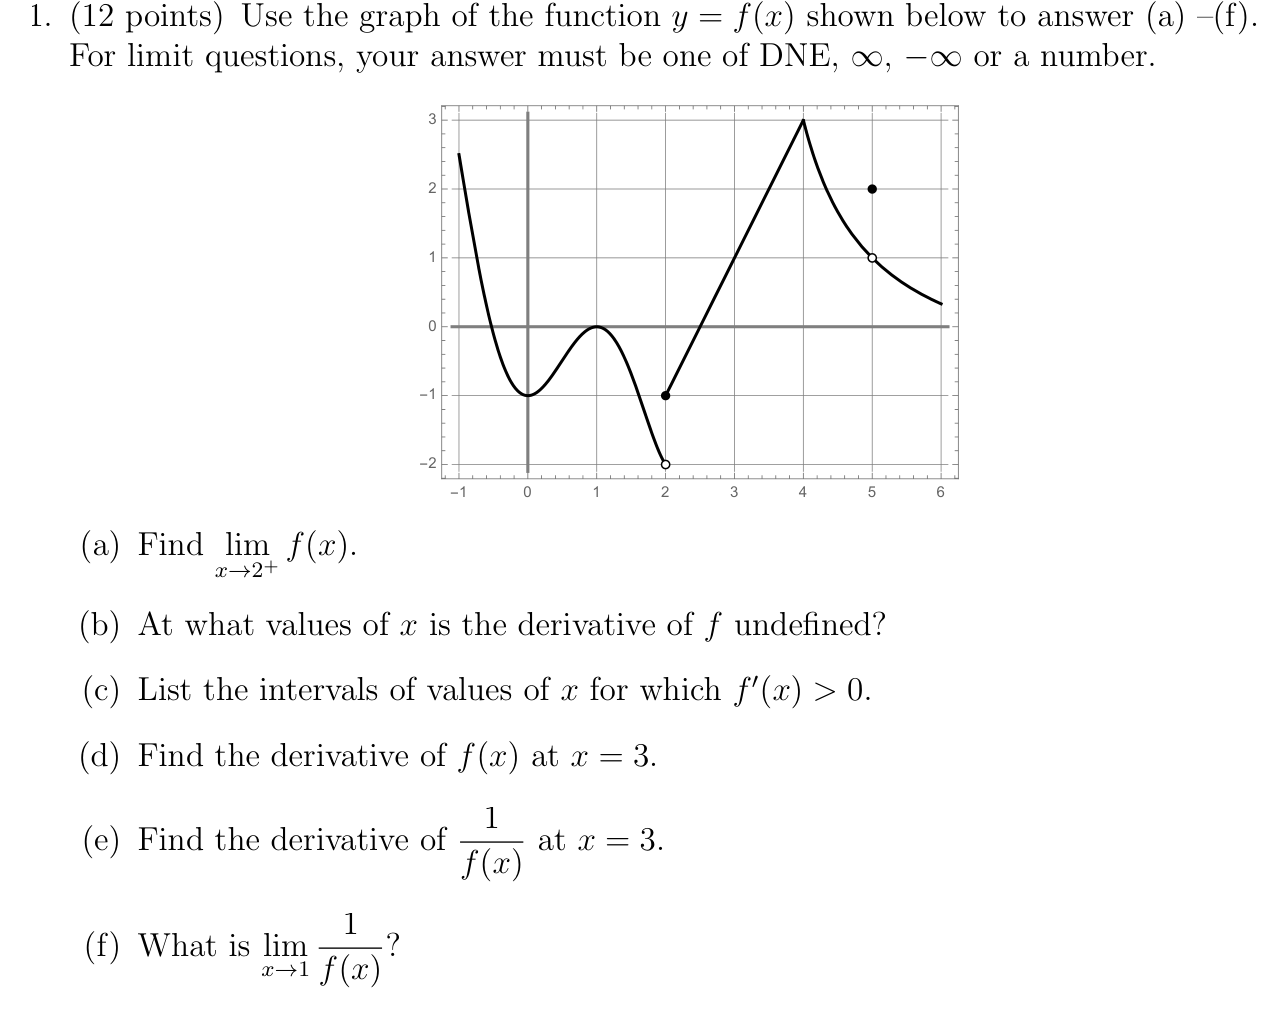
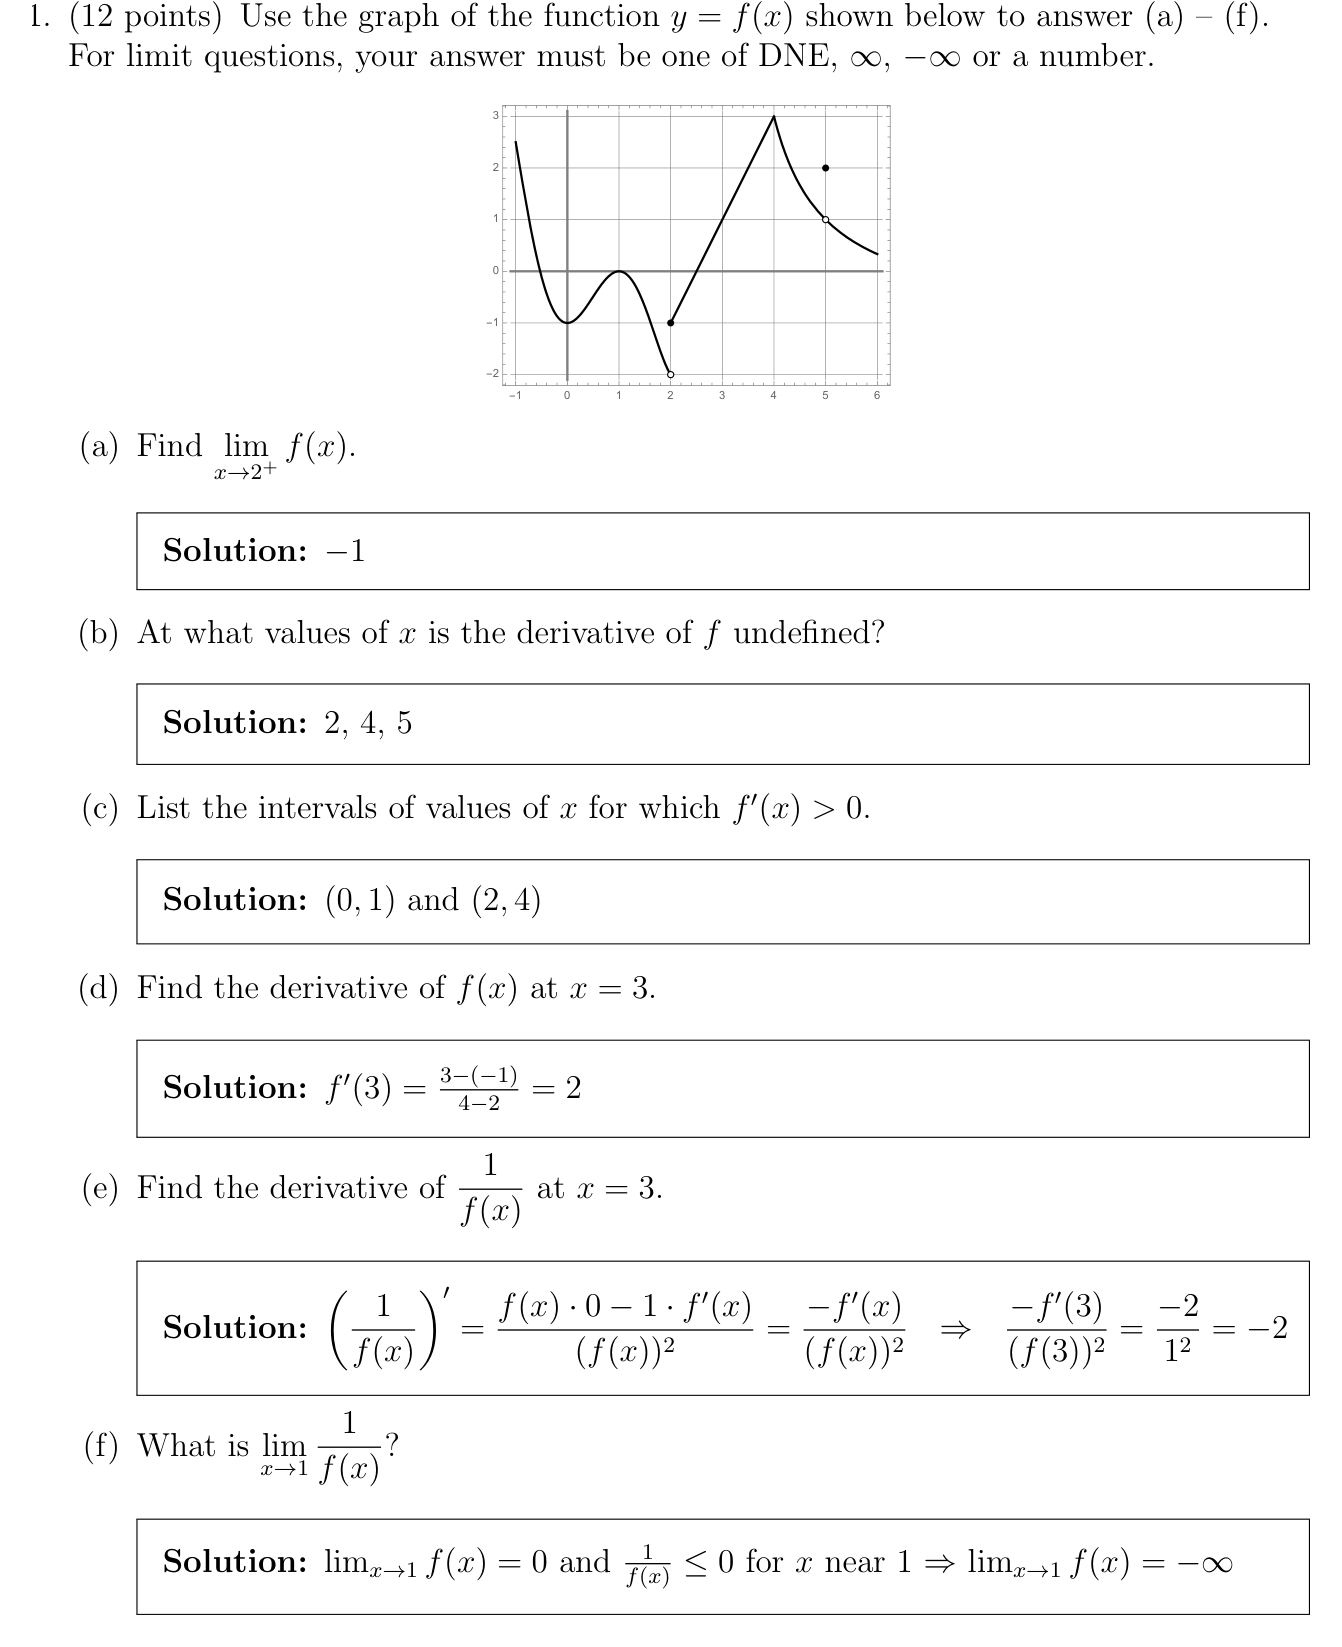
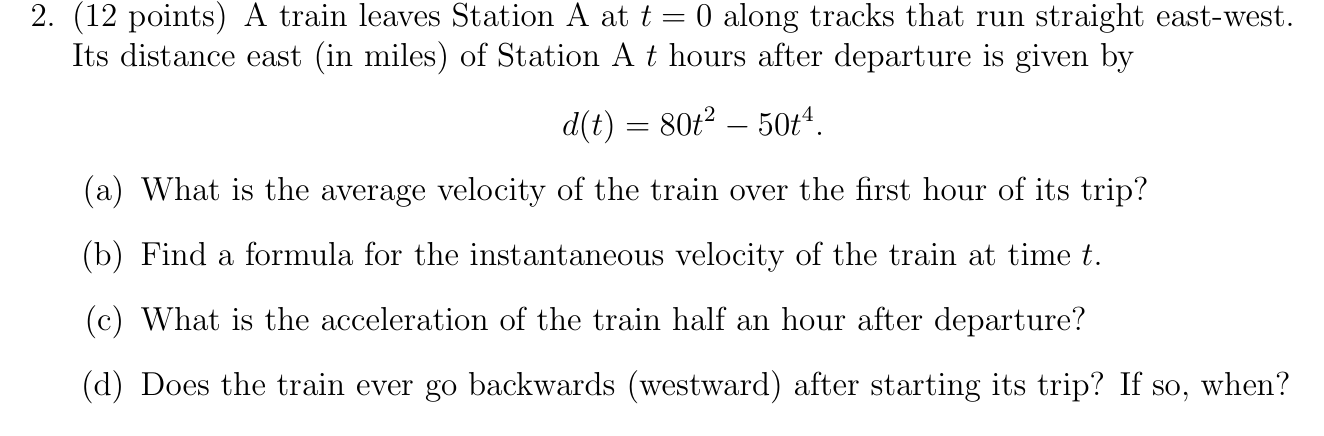
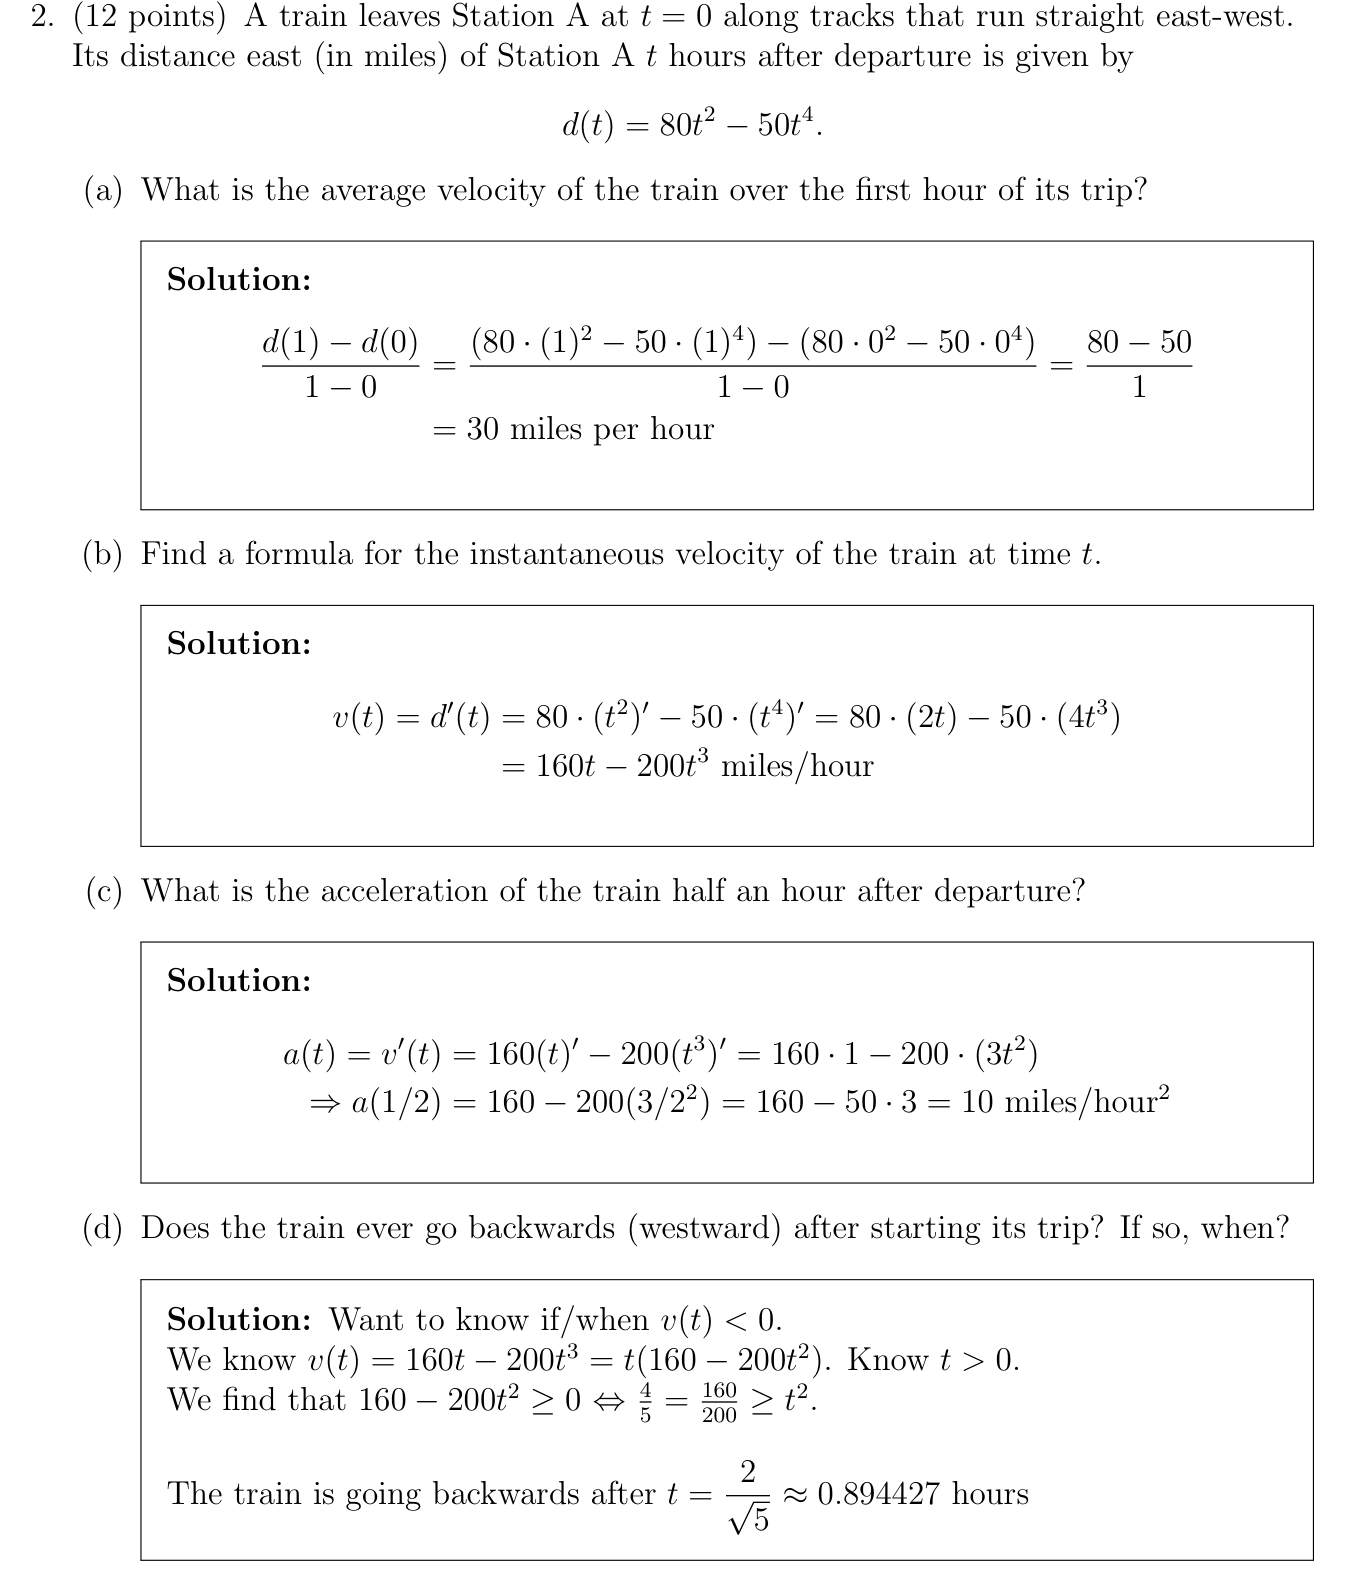
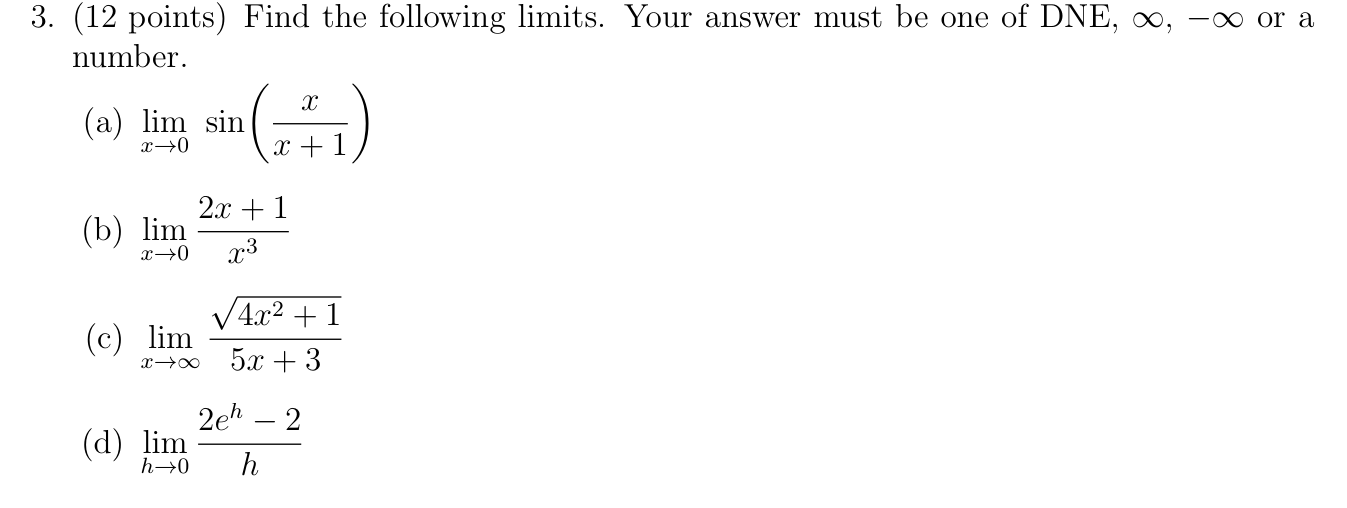
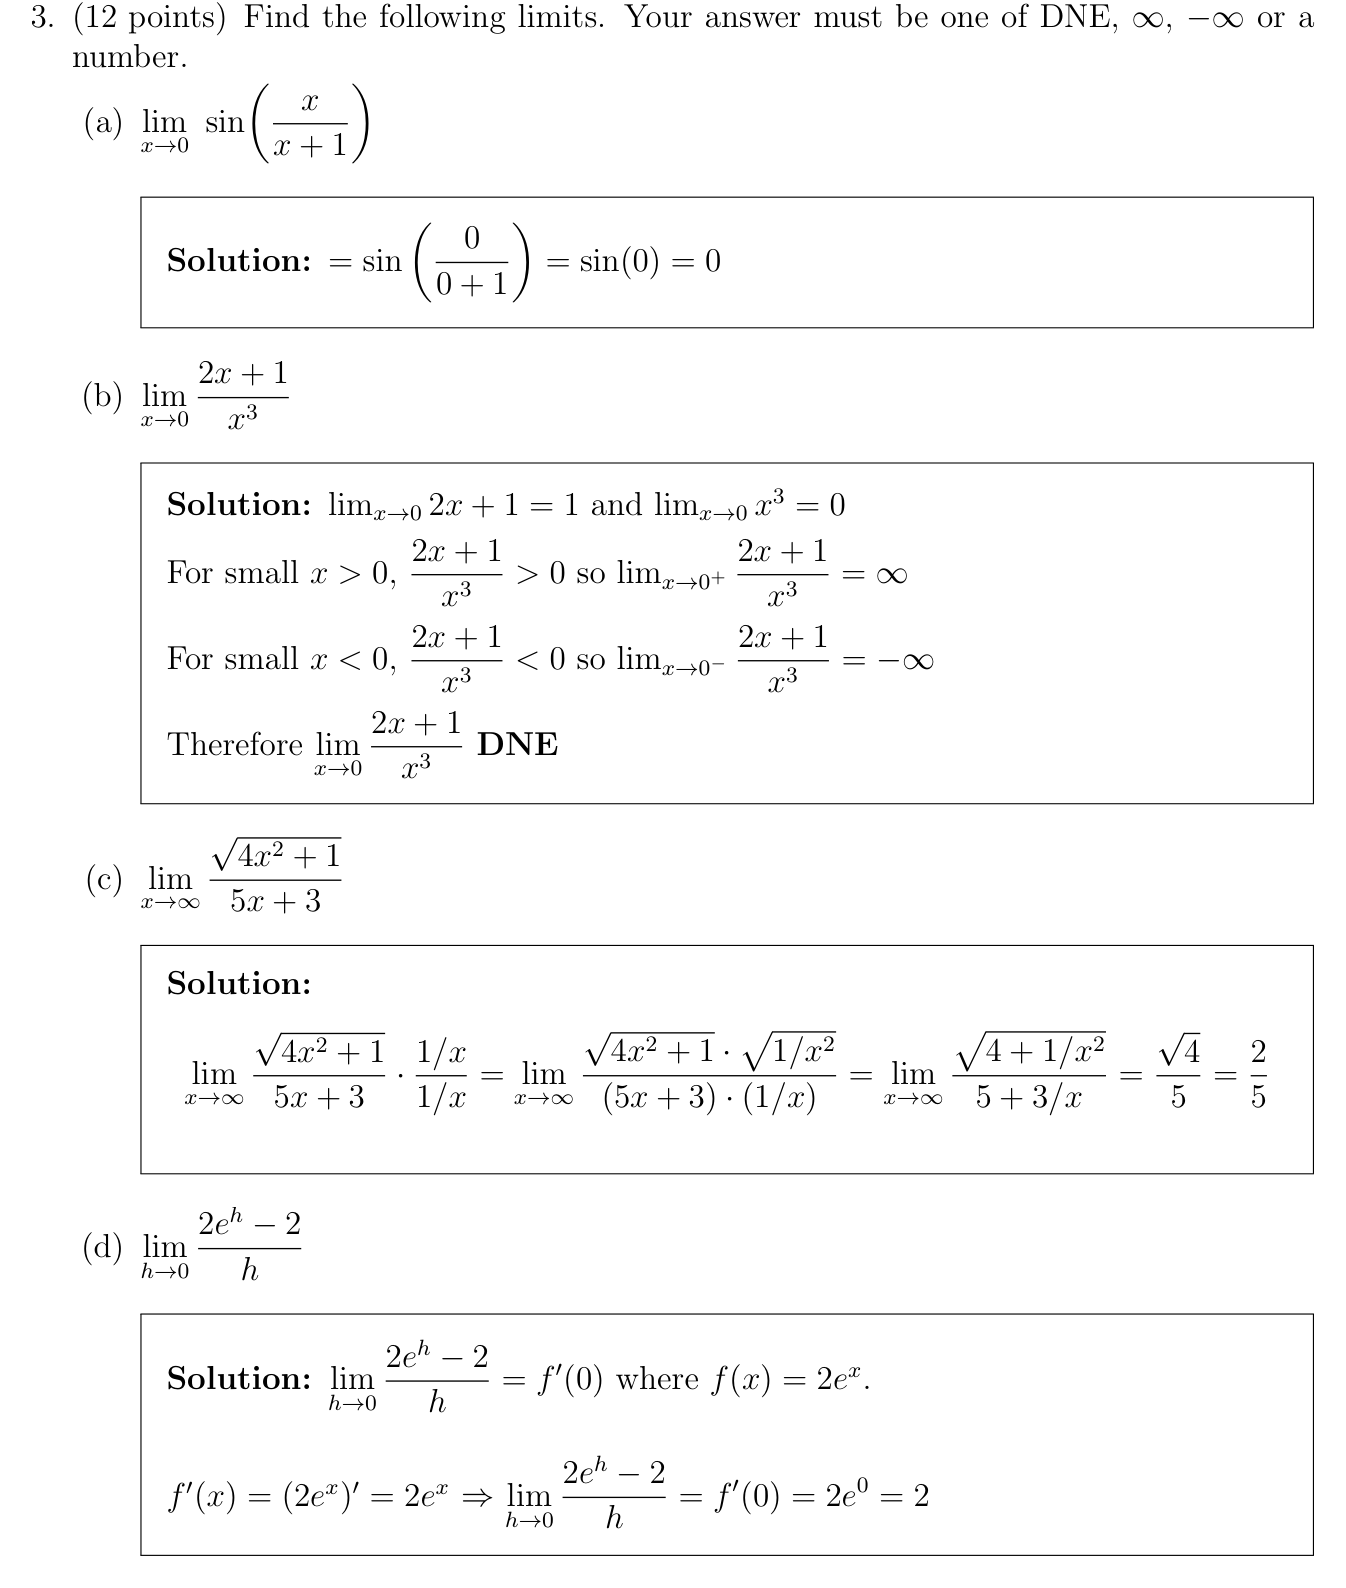
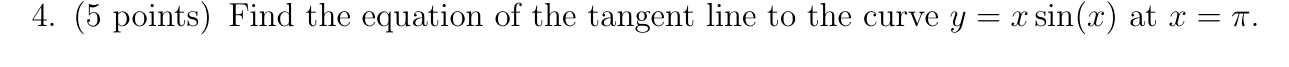
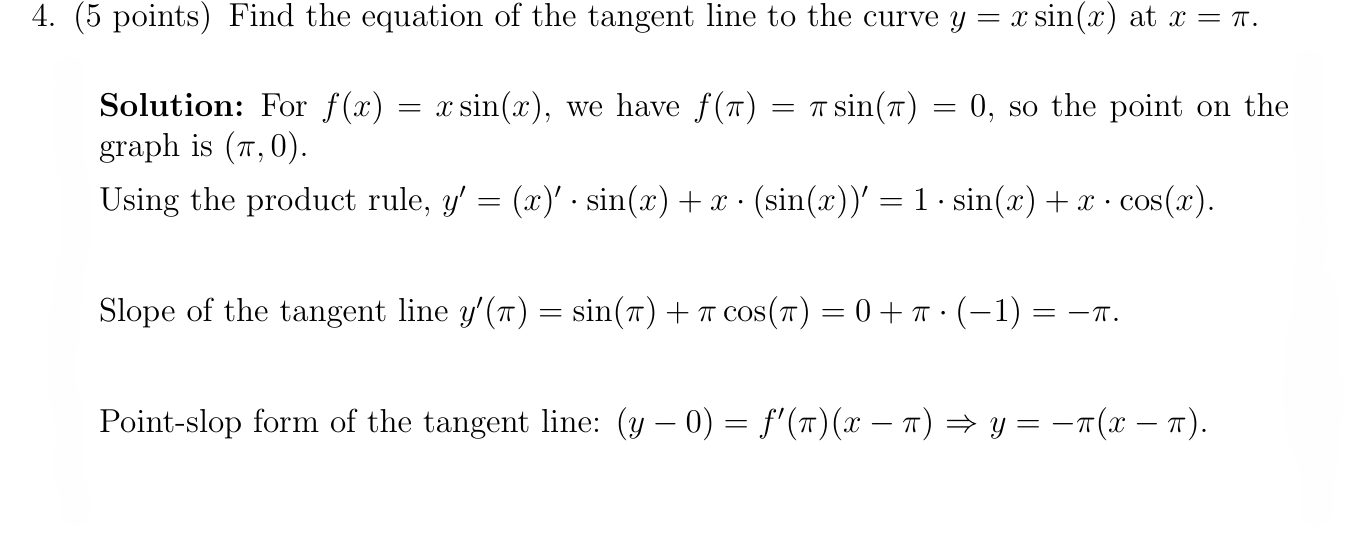
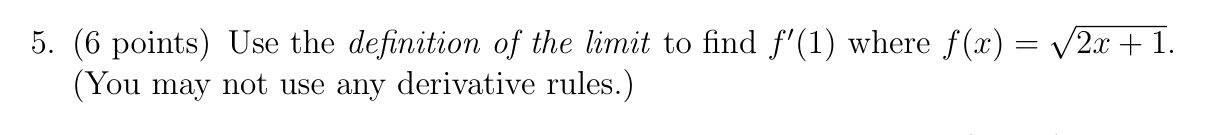
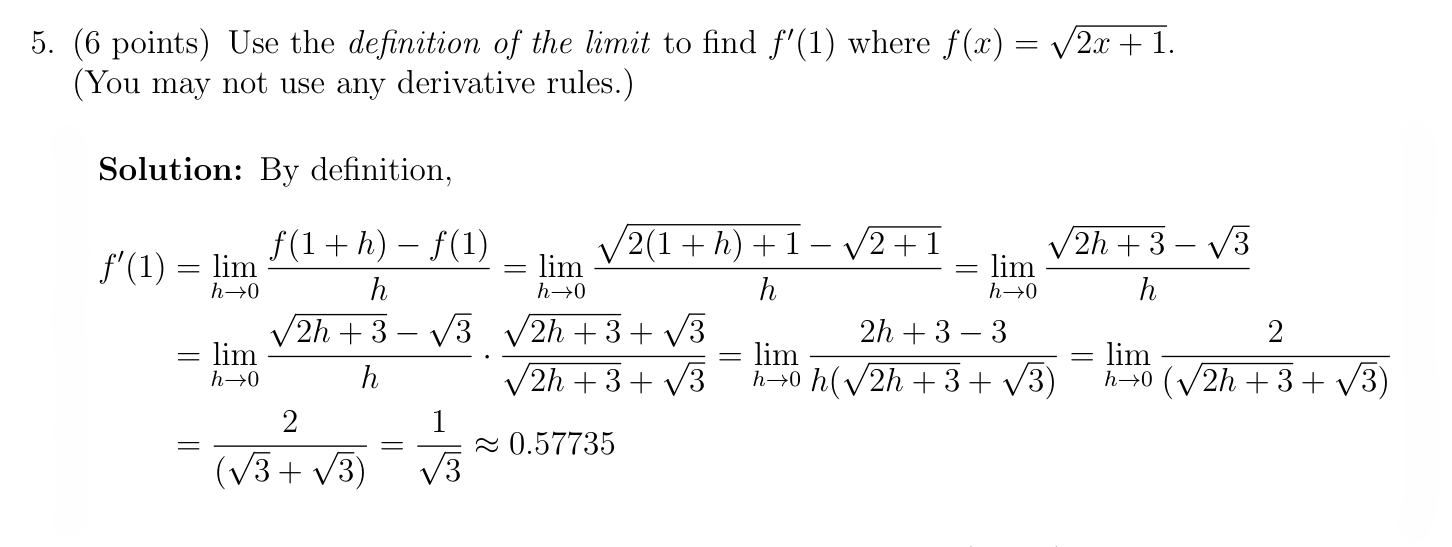
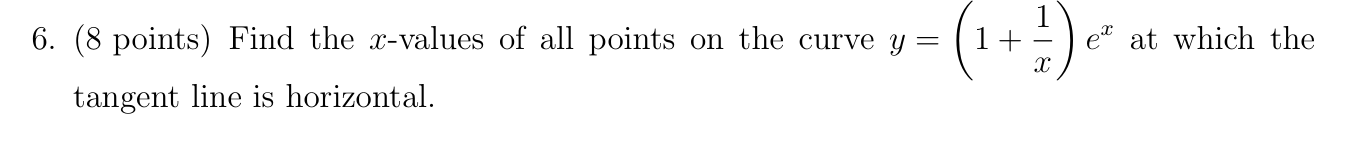
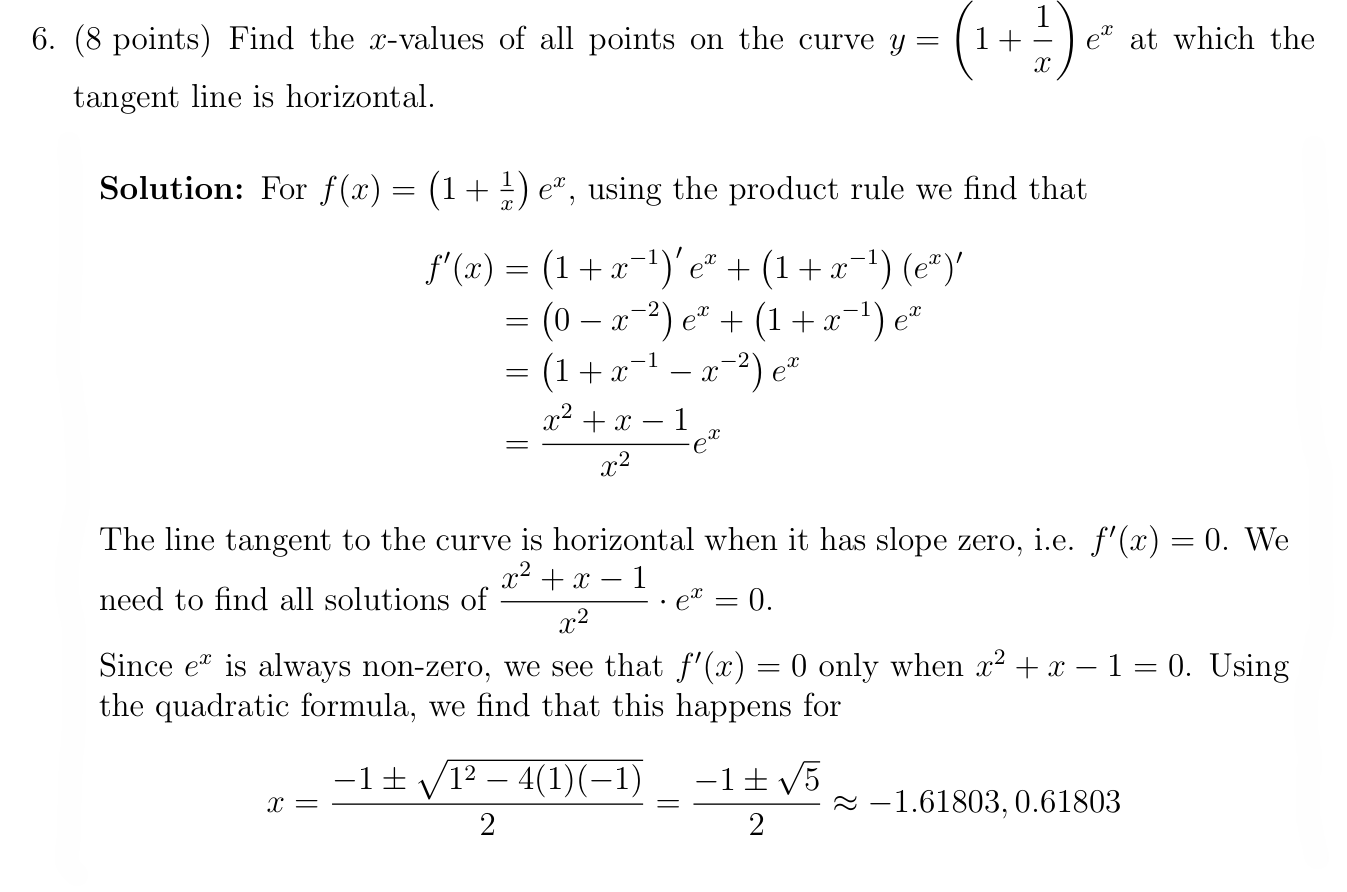

In [4]:
ARCHIVE_DIR = Path("../data/archive")
PROCESSED_DIR = Path("../data/processed")

archive_tests = 0
archive_questions = 0
for test_dir_path in ARCHIVE_DIR.iterdir():
    archive_tests += 1
    archive_questions += len(list(test_dir_path.iterdir())) - 1

print(f"Tests in archive: {archive_tests} ({archive_questions} questions)")

def img_tag(p: Path, max_h=220):
    b = p.read_bytes()
    mime = "image/png"
    b64 = base64.b64encode(b).decode("ascii")
    return f'<img src="data:{mime};base64,{b64}" style="max-height:{max_h}px;">'

print(f"Tests left: {len(list(PROCESSED_DIR.iterdir()))}")

for test_path in PROCESSED_DIR.iterdir():
    test_id = test_path.name

    rows = []
    for q_dir in sorted(p for p in test_path.iterdir() if p.is_dir()):
        q = (q_dir / "question.png").resolve()
        a = (q_dir / "answer.png").resolve()

        rows.append(
            f"""
            <tr>
              <td style="padding:8px; vertical-align:top; white-space:nowrap;">{q_dir.name}</td>
              <td style="padding:8px;">{img_tag(q)}</td>
              <td style="padding:8px;">{img_tag(a)}</td>
            </tr>
            """
        )

    html = f"""
    <div>
      <table border="0" cellspacing="0" cellpadding="0">
        <thead>
          <tr>
            <th style="text-align:left; padding:8px;">Q</th>
            <th style="text-align:left; padding:8px;">question.png</th>
            <th style="text-align:left; padding:8px;">answer.png</th>
          </tr>
        </thead>
        <tbody>
          {''.join(rows)}
        </tbody>
      </table>
    </div>
    """
    display(HTML(html))
    break

In [5]:
# happy and want to generate?
%run ../scripts/generate_question_metadatas -testId {test_id}

Generating question metadatas for test 0f5a3b3f-0607-4e65-91c9-b1bc4c553fcc
Q1: ✅
Q2: ✅
Q3: ✅
Q4: ✅
Q5: ✅
Q6: ✅


In [3]:
# unhappy and want to edit?
os.startfile(test_path.resolve())

Common Problems (i.e. not enough cropping):
- What if a question is split across pages and the professor was kind enough to repeat the question/diagram on the second page?
- Long, horizontal lines at the bottom of pages
- Version 2's being attached to last answer
- Need to crop "DO NOT WRITE..."

In [33]:
# unhappy and want to delete?
shutil.rmtree(test_path)

Common Problems (i.e. wrong or too much cropping)
- What if a non-question page has 1., 2. ...?
- Answer key is not sectioned correctly while questions are! Usually a previous answer contains part of the next one.
- Part of question erased!
- Diagram of a question partially above number